In [30]:
import os
from pydub import AudioSegment
import numpy as np
import matplotlib.pyplot as plt
from feature_extractors import MfccFeatureExtractor
from sklearn.manifold import TSNE
from scipy import *
import python_speech_features

In [11]:
def mfcc(y, sr, numcep=13, delta=False, delta_delta=False, width=2, **kwargs):
    """
    Compute MFCCs of Audio Signal
    :param y: Audio signal
    :param sr: Original sample rate
    :param numcep: Number of MFCCs to compute
    :param delta: If delta of MFCCs are required
    :param delta_delta: If acceleration of MFCCs are required
    :param width: Number of samples to consider for computing delta
    :param kwargs: Other parameters to pass on python_speech_features like hop length etc.
    :return: MFCCs (numpy array of shape n_frames * n_mfccs)
    """
    mfccs = python_speech_features.mfcc(signal=y, samplerate=sr, numcep=numcep, **kwargs)
    if delta:
        d1 = python_speech_features.delta(mfccs, N=width)
        mfccs = np.hstack((mfccs, d1))
    if delta_delta:
        d2 = python_speech_features.delta(mfccs[:, mfccs.shape[1] / 2:], N=width)
        mfccs = np.hstack((mfccs, d2))
    return mfccs

In [12]:
def remove_dc_offset(y):
    """
    Remove DC offset from audio signal
    :param y: Audio signal
    :return: Signal without DC offset
    """
    return y - np.mean(y)

In [13]:
def normalize_audio(y):
    """
    Normalize amplitudes to lie between -1 to 1
    :param y: Audio signal
    :return: Normalized Audio signal
    """
    # Todo : study other normalizing methods like rms normalizing
    y = y * 1.0
    return y / np.max(np.abs(y))

In [40]:
path = "/home/jugs/Downloads/PresidentAudio/" #"/home/jugs/PycharmProjects/THU_SR/src/Recordings/Zh/enroll/" #"/home/jugs/Downloads/o/pred_pres/" #"/home/jugs/Downloads/PresidentAudio/"   # "/home/jugs/Audio/default_voice/"
result = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if os.path.splitext(f)[1] == '.wav']
# audio = np.random.randint((6,512,13))   # Create MNIST Like stack of image
stacked = np.zeros((len(result),279552))  # for logmel(4 sec, 64 log,64 context) 
labels = []
files = []

In [41]:
for idx, file in enumerate(result):
    files.append(file)
#     print(file)
    labels.append(file.split('/')[5])
    feature_extraction = MfccFeatureExtractor(mfccs=13, context=64, stride=3)
    audio = AudioSegment.from_file(file)
    signal, sr = np.array(audio.get_array_of_samples(), dtype=float), float(audio.frame_rate)
#     print(signal)
    x_feat = feature_extraction(y=signal, sr=sr)
    stacked[idx] = (x_feat.flatten())  # nan_to_num
#     np.random.shuffle(stacked)
#     x = stacked[idx]
#     x[where(isinf(x))]= 0.0
#     y[idx] = x
#     y[where(isnan(y))]=0.0

In [101]:
# print(labels)
#print(stacked)

In [42]:
def plot_embedding(X, title="tsne dim reduction"):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], labels[i],
                 color= 'red',
                 fontdict={'weight': 'bold', 'size': 4})
    if title is not None:
        plt.title(title)

In [7]:
embedder = TSNE(n_components=2, perplexity=40, verbose=2, init='pca', random_state=0)
x_tsne = embedder.fit_transform(stacked)
# print(x_tsne)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 210 samples in 0.738s...
[t-SNE] Computed neighbors for 210 samples in 18.152s...
[t-SNE] Computed conditional probabilities for sample 210 / 210
[t-SNE] Mean sigma: 2264.259482
[t-SNE] Computed conditional probabilities in 0.034s
[t-SNE] Iteration 50: error = 45.3256989, gradient norm = 0.0027620 (50 iterations in 0.324s)
[t-SNE] Iteration 100: error = 47.2887764, gradient norm = 0.0021554 (50 iterations in 0.171s)
[t-SNE] Iteration 150: error = 54.6307259, gradient norm = 0.0093416 (50 iterations in 0.186s)
[t-SNE] Iteration 200: error = 61.4010811, gradient norm = 0.0044378 (50 iterations in 0.164s)
[t-SNE] Iteration 250: error = 80.6661148, gradient norm = 0.0376346 (50 iterations in 0.165s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.666115
[t-SNE] Iteration 300: error = 1.5081038, gradient norm = 0.0010701 (50 iterations in 0.175s)
[t-SNE] Iteration 350: error = 1.1602831, gradient norm = 0.0004

In [9]:
print(x_tsne.shape)
print(stacked.shape)

(210, 2)
(210, 279552)


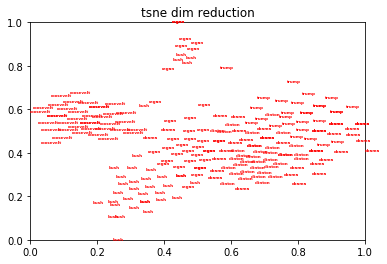

In [10]:
plot_embedding(x_tsne)
plt.savefig("logmel.png", bbox_inches='tight', dpi=720)
plt.show()